In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

# Input data files are available in the read-only "../data/" directory

# Load the train data
train_values_file_path = '../data/train-set-values.csv'
train_values = pd.read_csv(train_values_file_path)
X = train_values.copy()

train_labels_file_path = '../data/train-set-labels.csv'
train_labels = pd.read_csv(train_labels_file_path)
y = train_labels.copy()

X_y = pd.concat([X.set_index('id'),y.set_index('id')], axis=1, join='inner').reset_index()

# Load the test data
test_file_path = '../data/test-set-values.csv'
test_values = pd.read_csv(test_file_path)
X_test = test_values.copy()

## pre-processing 

In the pre-pcessing step, we'll try to convert some of the useful features identified in EDA, into a form that can be fed to a ML model. We'll store that set of features in a data frame called `features_X` for 'train data' and `features_X_test` for 'test data'.

#### `funder`

As observed in EDA, `funder` has 1897 unique values (Some of which are due to spelling errors, capitalization errors, and data entry errors)

Lets first convert everything to lowecase to try and minimize capitalization errors if any

In [2]:
funder = X['funder'].astype(str)
funder = funder.str.lower()

funder_test = X_test['funder'].astype(str)
funder_test = funder_test.str.lower()

Then lets identify the values which are most likely to be the same and then replace similar values with one value. Function `replace_similar_categories` is written for this purpose. It uses the FuzzyWuzzy Package to calculate string similarity using Levenshtein distance ratio of similarity.

ref: https://www.datacamp.com/community/tutorials/fuzzy-string-python
 

In [3]:
from fuzzywuzzy import fuzz
from collections import defaultdict

def get_similar_categories(sr, threshold):
    replacements_dict = defaultdict(lambda: "other")
    unique_list = []

    for category in sr.unique():    
        is_unique = True
        replacements_dict[category] = category
        for unique_category in unique_list:        
            if (fuzz.ratio(category, unique_category) > threshold):
                replacements_dict[category] = unique_category
                is_unique = False
    #             print (category + " replaced by " + unique_category)
                break            
        if(is_unique):
            unique_list.append(category)    
    
    return replacements_dict

In [4]:
funder_similar_category_replacements = get_similar_categories(funder, 85)

In [5]:
funder = funder.map(funder_similar_category_replacements)
funder_test = funder_test.map(funder_similar_category_replacements)

Then lets replace the categories that occur less than 2% of the time with 'other'. Number 2% was empirically determined as a number that yields a reasonable number of categories.  

In [6]:
def get_less_occuring_categories(sr, threshold):
    val_counts = sr.value_counts(normalize=True)
    replacements_dict = defaultdict(lambda: "other")

    for category in sr.unique():
        if(val_counts.at[category] < threshold):
            replacements_dict[category] = 'other'
        else:
            replacements_dict[category] = category
    return replacements_dict        

In [7]:
funder_less_occuring_category_replacements = get_less_occuring_categories(funder, 0.02)

In [8]:
funder = funder.map(funder_less_occuring_category_replacements)
funder_test = funder_test.map(funder_less_occuring_category_replacements)

In [9]:
len(funder.unique())

9

In [10]:
features_X = funder.to_frame()
features_X_test = funder_test.to_frame()

#### `installer`

Since `installer` is very similar to `funder` in nature, we'll use the same preprocessing steps to `installer` as well.

In [11]:
installer = X['installer'].astype(str)
installer = installer.str.lower()

installer_test = X_test['installer'].astype(str)
installer_test = installer_test.str.lower()

installer_similar_category_replacements = get_similar_categories(installer, 85)

installer = installer.map(installer_similar_category_replacements)
installer_test = installer_test.map(installer_similar_category_replacements)

installer_less_occuring_category_replacements = get_less_occuring_categories(installer, 0.02)

installer = installer.map(installer_less_occuring_category_replacements)
installer_test = installer_test.map(installer_less_occuring_category_replacements)

In [12]:
len(installer.unique())

7

In [13]:
features_X = features_X.merge(installer, left_index=True, right_index=True)
features_X_test = features_X_test.merge(installer_test, left_index=True, right_index=True)
features_X

,funder,installer
0,other,other
1,other,other
2,other,other
3,other,other
4,other,other
...,...,...
59395,other,other
59396,other,other
59397,nan,nan
59398,other,other


#### `basin`

We can directly use `basin` as it contains only 9 categories.

In [14]:
features_X = features_X.merge(X['basin'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['basin'], left_index=True, right_index=True)
features_X

,funder,installer,basin
0,other,other,Lake Nyasa
1,other,other,Lake Victoria
2,other,other,Pangani
3,other,other,Ruvuma / Southern Coast
4,other,other,Lake Victoria
...,...,...,...
59395,other,other,Pangani
59396,other,other,Rufiji
59397,nan,nan,Rufiji
59398,other,other,Rufiji


#### Features related to the Geographical location

We'll consider `gps_height`, `longitude`, `latitude`, and, `region` to represent Geographical data. We'll first handle outliers

In [15]:
num_geo_features = X[['gps_height', 'longitude', 'latitude', 'region']]

Q1 = num_geo_features.quantile(0.25)
Q3 = num_geo_features.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

gps_height    1319.250000
longitude        4.088039
latitude         5.214466
dtype: float64


We'll replace outliers with the median value of their region. 

In [16]:
new_num_geo_features = pd.DataFrame()

for feature in ['gps_height', 'longitude', 'latitude']:
    lower_whisker = Q1[feature] - 1.5 * IQR[feature]
    higher_whisker = Q3[feature] + 1.5 * IQR[feature] 
    
    new_num_geo_features[feature] = num_geo_features[feature].apply(lambda x: np.nan if (x < lower_whisker or x > higher_whisker) else x)

In [17]:
new_num_geo_features['region'] = num_geo_features['region']

In [18]:
for feature in ['gps_height', 'longitude', 'latitude']:
    new_num_geo_features[feature].fillna(new_num_geo_features.groupby('region')[feature].transform('median'))

Applying the same for the test data set

In [19]:
num_geo_features_test = X[['gps_height', 'longitude', 'latitude', 'region']]

new_num_geo_features_test = pd.DataFrame()

for feature in ['gps_height', 'longitude', 'latitude']:
    lower_whisker = Q1[feature] - 1.5 * IQR[feature]
    higher_whisker = Q3[feature] + 1.5 * IQR[feature] 
    
    new_num_geo_features_test[feature] = num_geo_features_test[feature].apply(lambda x: np.nan if (x < lower_whisker or x > higher_whisker) else x)
    
new_num_geo_features_test['region'] = num_geo_features_test['region']

for feature in ['gps_height', 'longitude', 'latitude']:
    new_num_geo_features_test[feature].fillna(new_num_geo_features.groupby('region')[feature].transform('median'))

In [20]:
features_X = features_X.merge(new_num_geo_features, left_index=True, right_index=True)
features_X_test = features_X_test.merge(new_num_geo_features_test, left_index=True, right_index=True)

features_X

,funder,installer,basin,gps_height,longitude,latitude,region
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara
2,other,other,Pangani,686,37.460664,-3.821329,Manyara
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera
...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma


#### Feature related to Operation and Management

Out of the similar features identified in EDA, lets choose `management` as the feature to represent operation and management information.

In [21]:
features_X = features_X.merge(X['management'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['management'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other
...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc


#### Feature related to Extraction Type

Out of the similar features identified in EDA, lets choose `extraction_type_class` as the feature to represent operation and management information.

In [22]:
features_X = features_X.merge(X['extraction_type_class'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['extraction_type_class'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity
...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump


#### Feature related to Cost

Out of the similar features identified in EDA, lets choose `payment` as the feature to represent cost type.

In [23]:
features_X = features_X.merge(X['payment'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['payment'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay
...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay


#### Features related to Quantity

Out of the similar features identified in EDA, lets choose `quantity_group` as the feature to represent water quantity.

In [24]:
features_X = features_X.merge(X['quantity_group'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['quantity_group'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quantity_group
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,enough
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,insufficient
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,enough
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,dry
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,seasonal
...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,enough
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,enough
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,enough
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,insufficient


#### Features related to Source

Out of the similar features identified in EDA, lets choose `source_type` and `source_class` as the features to represent source.

In [25]:
features_X = features_X.merge(X['source_type'], left_index=True, right_index=True)

features_X_test = features_X_test.merge(X_test['source_type'], left_index=True, right_index=True)

features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quantity_group,source_type
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,enough,spring
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,insufficient,rainwater harvesting
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,enough,dam
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,dry,borehole
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,seasonal,rainwater harvesting
...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,enough,spring
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,enough,river/lake
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,enough,borehole
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,insufficient,shallow well


#### Feature related to Waterpoint Type

Out of the similar features identified in EDA, lets choose `waterpoint_type` as the feature to represent waterpoint type.

In [26]:
features_X = features_X.merge(X['waterpoint_type'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['waterpoint_type'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quantity_group,source_type,waterpoint_type
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,enough,spring,communal standpipe
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,insufficient,rainwater harvesting,communal standpipe
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,enough,dam,communal standpipe multiple
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,dry,borehole,communal standpipe multiple
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,seasonal,rainwater harvesting,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,enough,spring,communal standpipe
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,enough,river/lake,communal standpipe
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,enough,borehole,hand pump
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,insufficient,shallow well,hand pump


#### Feature related to TSH

we'll consider the `amount_tsh` feature as well

In [27]:
features_X = features_X.merge(X['amount_tsh'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['amount_tsh'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quantity_group,source_type,waterpoint_type,amount_tsh
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,enough,spring,communal standpipe,6000.0
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,insufficient,rainwater harvesting,communal standpipe,0.0
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,enough,dam,communal standpipe multiple,25.0
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,dry,borehole,communal standpipe multiple,0.0
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,seasonal,rainwater harvesting,communal standpipe,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,enough,spring,communal standpipe,10.0
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,enough,river/lake,communal standpipe,4700.0
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,enough,borehole,hand pump,0.0
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,insufficient,shallow well,hand pump,0.0


#### Other Features

`permit`

In [28]:
features_X = features_X.merge(X['permit'], left_index=True, right_index=True)
features_X_test = features_X_test.merge(X_test['permit'], left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quantity_group,source_type,waterpoint_type,amount_tsh,permit
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,enough,spring,communal standpipe,6000.0,False
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,insufficient,rainwater harvesting,communal standpipe,0.0,True
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,enough,dam,communal standpipe multiple,25.0,True
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,dry,borehole,communal standpipe multiple,0.0,True
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,seasonal,rainwater harvesting,communal standpipe,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,enough,spring,communal standpipe,10.0,True
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,enough,river/lake,communal standpipe,4700.0,True
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,enough,borehole,hand pump,0.0,False
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,insufficient,shallow well,hand pump,0.0,True


`population`

As seen in EDA, population also contained many outliers. Even the 25th quartile was 0. We'll try to replace those 0's with nan so that they will be later replaced with the mean value (in the pipeline)

In [29]:
population_df = pd.DataFrame()
population_df['population'] = X['population'].apply(lambda x: np.nan if x == 0 else x)

population_test_df = pd.DataFrame()
population_test_df['population'] = X_test['population'].apply(lambda x: np.nan if x == 0 else x)

population_df

,population
0,109.0
1,280.0
2,250.0
3,58.0
4,NaN
...,...
59395,125.0
59396,56.0
59397,NaN
59398,NaN


In [30]:
features_X = features_X.merge(population_df, left_index=True, right_index=True)
features_X_test = features_X_test.merge(population_test_df, left_index=True, right_index=True)
features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quantity_group,source_type,waterpoint_type,amount_tsh,permit,population
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,enough,spring,communal standpipe,6000.0,False,109.0
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,insufficient,rainwater harvesting,communal standpipe,0.0,True,280.0
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,enough,dam,communal standpipe multiple,25.0,True,250.0
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,dry,borehole,communal standpipe multiple,0.0,True,58.0
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,seasonal,rainwater harvesting,communal standpipe,0.0,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,enough,spring,communal standpipe,10.0,True,125.0
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,enough,river/lake,communal standpipe,4700.0,True,56.0
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,enough,borehole,hand pump,0.0,False,NaN
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,insufficient,shallow well,hand pump,0.0,True,NaN


## Feature Engineering

#### New Feature to represent pump age

We'll add a new feature to represent pump age using the data given in `construction_year`.

In [31]:
pump_age = 2013 - X['construction_year']
pump_age.replace(2013, np.nan, inplace=True)
pump_age.name = "pump_age"

pump_age_test = 2013 - X['construction_year']
pump_age_test.replace(2013, np.nan, inplace=True)
pump_age_test.name = "pump_age"


In [32]:
features_X = features_X.merge(pump_age, left_index=True, right_index=True)
features_X_test = features_X_test.merge(pump_age_test, left_index=True, right_index=True)

features_X

,funder,installer,basin,gps_height,longitude,latitude,region,management,extraction_type_class,payment,quantity_group,source_type,waterpoint_type,amount_tsh,permit,population,pump_age
0,other,other,Lake Nyasa,1390,34.938093,-9.856322,Iringa,vwc,gravity,pay annually,enough,spring,communal standpipe,6000.0,False,109.0,14.0
1,other,other,Lake Victoria,1399,34.698766,-2.147466,Mara,wug,gravity,never pay,insufficient,rainwater harvesting,communal standpipe,0.0,True,280.0,3.0
2,other,other,Pangani,686,37.460664,-3.821329,Manyara,vwc,gravity,pay per bucket,enough,dam,communal standpipe multiple,25.0,True,250.0,4.0
3,other,other,Ruvuma / Southern Coast,263,38.486161,-11.155298,Mtwara,vwc,submersible,never pay,dry,borehole,communal standpipe multiple,0.0,True,58.0,27.0
4,other,other,Lake Victoria,0,31.130847,-1.825359,Kagera,other,gravity,never pay,seasonal,rainwater harvesting,communal standpipe,0.0,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,1210,37.169807,-3.253847,Kilimanjaro,water board,gravity,pay per bucket,enough,spring,communal standpipe,10.0,True,125.0,14.0
59396,other,other,Rufiji,1212,35.249991,-9.070629,Iringa,vwc,gravity,pay annually,enough,river/lake,communal standpipe,4700.0,True,56.0,17.0
59397,nan,nan,Rufiji,0,34.017087,-8.750434,Mbeya,vwc,handpump,pay monthly,enough,borehole,hand pump,0.0,False,NaN,NaN
59398,other,other,Rufiji,0,35.861315,-6.378573,Dodoma,vwc,handpump,never pay,insufficient,shallow well,hand pump,0.0,True,NaN,NaN


## Feature Encoding

### Transformers for features

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import gen_features

#### Trasformer for Categorical data

In [34]:
categorical_cols = [col for col in features_X.columns if features_X[col].dtype == "object"]
categorical_cols_2d = [[col] for col in categorical_cols]
print(categorical_cols)

gen_categorical = gen_features(
    columns = categorical_cols_2d,
    classes=[
        {
            "class": SimpleImputer,
            "strategy": "most_frequent"
        }
    ]
)

['funder', 'installer', 'basin', 'region', 'management', 'extraction_type_class', 'payment', 'quantity_group', 'source_type', 'waterpoint_type', 'permit']


#### Trasformer for Numerical data

In [35]:
lat_long = ['latitude', 'longitude']
lat_long_2d = [[col] for col in lat_long]

gen_lat_long = gen_features(
    columns = lat_long_2d,
    classes=[
        {
            "class": SimpleImputer,
            "strategy": "mean"
        },
        StandardScaler
    ]
)

In [36]:
numerical_cols = [col for col in features_X.columns if features_X[col].dtype in ['int64', 'float64']]
numerical_cols.remove('latitude')
numerical_cols.remove('longitude')

numerical_cols_2d = [[col] for col in numerical_cols]
print(numerical_cols)

gen_numerical = gen_features(
    columns = numerical_cols_2d,
    classes=[
        {
            "class": SimpleImputer,
            "strategy": "mean"
        }
    ]
)

['gps_height', 'amount_tsh', 'population', 'pump_age']


### DFMapper

In [37]:
from sklearn_pandas import DataFrameMapper

feature_def = []
feature_def.extend(gen_categorical)
feature_def.extend(gen_lat_long)
feature_def.extend(gen_numerical)

preprocess_mapper = DataFrameMapper(
    feature_def,
    input_df=True,
    df_out=True
)

feature_def

[(['funder'], [SimpleImputer(strategy='most_frequent')], {}),
 (['installer'], [SimpleImputer(strategy='most_frequent')], {}),
 (['basin'], [SimpleImputer(strategy='most_frequent')], {}),
 (['region'], [SimpleImputer(strategy='most_frequent')], {}),
 (['management'], [SimpleImputer(strategy='most_frequent')], {}),
 (['extraction_type_class'], [SimpleImputer(strategy='most_frequent')], {}),
 (['payment'], [SimpleImputer(strategy='most_frequent')], {}),
 (['quantity_group'], [SimpleImputer(strategy='most_frequent')], {}),
 (['source_type'], [SimpleImputer(strategy='most_frequent')], {}),
 (['waterpoint_type'], [SimpleImputer(strategy='most_frequent')], {}),
 (['permit'], [SimpleImputer(strategy='most_frequent')], {}),
 (['latitude'], [SimpleImputer(), StandardScaler()], {}),
 (['longitude'], [SimpleImputer(), StandardScaler()], {}),
 (['gps_height'], [SimpleImputer()], {}),
 (['amount_tsh'], [SimpleImputer()], {}),
 (['population'], [SimpleImputer()], {}),
 (['pump_age'], [SimpleImputer(

### Proprocessor

In [38]:
tranformed_df = preprocess_mapper.fit_transform(features_X)
tranformed_df

,funder,installer,basin,region,management,extraction_type_class,payment,quantity_group,source_type,waterpoint_type,permit,latitude,longitude,gps_height,amount_tsh,population,pump_age
0,other,other,Lake Nyasa,Iringa,vwc,gravity,pay annually,enough,spring,communal standpipe,False,-1.408791,-0.082411,1390.0,6000.0,109.000000,14.000000
1,other,other,Lake Victoria,Mara,wug,gravity,never pay,insufficient,rainwater harvesting,communal standpipe,True,1.207934,-0.175631,1399.0,0.0,280.000000,3.000000
2,other,other,Pangani,Manyara,vwc,gravity,pay per bucket,enough,dam,communal standpipe multiple,True,0.639751,0.900156,686.0,25.0,250.000000,4.000000
3,other,other,Ruvuma / Southern Coast,Mtwara,vwc,submersible,never pay,dry,borehole,communal standpipe multiple,True,-1.849720,1.299597,263.0,0.0,58.000000,27.000000
4,other,other,Lake Victoria,Kagera,other,gravity,never pay,seasonal,rainwater harvesting,communal standpipe,True,1.317271,-1.565372,0.0,0.0,281.087167,16.185314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,other,other,Pangani,Kilimanjaro,water board,gravity,pay per bucket,enough,spring,communal standpipe,True,0.832379,0.786864,1210.0,10.0,125.000000,14.000000
59396,other,other,Rufiji,Iringa,vwc,gravity,pay annually,enough,river/lake,communal standpipe,True,-1.142092,0.039076,1212.0,4700.0,56.000000,17.000000
59397,nan,nan,Rufiji,Mbeya,vwc,handpump,pay monthly,enough,borehole,hand pump,False,-1.033404,-0.441152,0.0,0.0,281.087167,16.185314
59398,other,other,Rufiji,Dodoma,vwc,handpump,never pay,insufficient,shallow well,hand pump,True,-0.228290,0.277193,0.0,0.0,281.087167,16.185314


## Modelling

### Model

Since the dataset contains a majority of categorical values, a catboost model is tired out here.

In [39]:
from catboost import CatBoostClassifier

def make_cb_model(iterations=1000):
    return CatBoostClassifier(
        iterations=iterations,
        random_state=0,
        cat_features=categorical_cols,
        verbose=500
)

### Pipeline

In [40]:
def make_my_pipeline(preprocessor, model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

### Measure 5-fold cross validation accuaracy

In [41]:
from sklearn.model_selection import cross_validate

def get_cross_val_accuracy(pipeline, k):
    scores = cross_validate(pipeline, features_X, y['status_group'], cv=k, scoring='accuracy', return_train_score=True)
    test_scores = scores['test_score']
    train_scores = scores['train_score']
    return {
        'test': test_scores.mean(), 
        'train': train_scores.mean()  
    }

### Tuning number of iterations

In [ ]:
# k = 5  ## k in k-fold cross validation
# results = {}

# for iterations in range(5000, 5001, 2000):
#     model = make_cb_model(iterations = iterations)
#     pipeline = make_my_pipeline(preprocess_mapper, model)
#     test_train_cross_val_accuracy = get_cross_val_accuracy(pipeline, k)
#     results[iterations] = test_train_cross_val_accuracy

# results

In [43]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# plt.figure(figsize=(10, 10))

# for key in results.keys():
#     plt.plot(list(results[key].keys()), [res_dict['test'] for res_dict in list(results[key].values())])

# plt.legend(list(results.keys()))
    
# plt.show()

In [47]:
final_model = make_cb_model(iterations=10000)
final_pipeline = make_my_pipeline(preprocess_mapper, final_model)

In [48]:
final_pipeline.fit(features_X, y['status_group'])

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.013925
0:	learn: 1.0880844	total: 105ms	remaining: 17m 25s
500:	learn: 0.5956315	total: 56.3s	remaining: 17m 48s
1000:	learn: 0.5615718	total: 1m 58s	remaining: 17m 43s
1500:	learn: 0.5423101	total: 3m 1s	remaining: 17m 6s
2000:	learn: 0.5297532	total: 4m 4s	remaining: 16m 18s
2500:	learn: 0.5199528	total: 5m 4s	remaining: 15m 12s
3000:	learn: 0.5112687	total: 6m 9s	remaining: 14m 22s
3500:	learn: 0.5036963	total: 7m 16s	remaining: 13m 29s
4000:	learn: 0.4971099	total: 8m 22s	remaining: 12m 33s
4500:	learn: 0.4910889	total: 9m 28s	remaining: 11m 34s
5000:	learn: 0.4854959	total: 10m 35s	remaining: 10m 35s
5500:	learn: 0.4801191	total: 11m 43s	remaining: 9m 35s
6000:	learn: 0.4752918	total: 12m 48s	remaining: 8m 32s
6500:	learn: 0.4705249	total: 13m 54s	remaining: 7m 29s
7000:	learn: 0.4660841	total: 14m 58s	remaining: 6m 24s
7500:	learn: 0.4616289	total: 16m 2s	remaining: 5m 20s
8000:	learn: 0.4574945	total: 17m 6s	remaining: 4m 16s
8500:	learn: 0.4534671	total: 

Pipeline(steps=[('preprocessor',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['funder'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {}),
                                           (['installer'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {}),
                                           (['basin'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {}),
                                           (['region'],
                                            [SimpleImputer(strategy='most_frequent')],
                                            {}),
                                           (['management'],
                                            [SimpleImputer(st...
            

## Insight-Extraction

### Feature Importance

In [49]:
feature_importance = final_model.get_feature_importance(type="FeatureImportance")

In [50]:
feature_importance_df = pd.DataFrame(feature_importance, columns=['importance'])
feature_importance_df['feature'] = tranformed_df.columns

<AxesSubplot:xlabel='importance', ylabel='feature'>

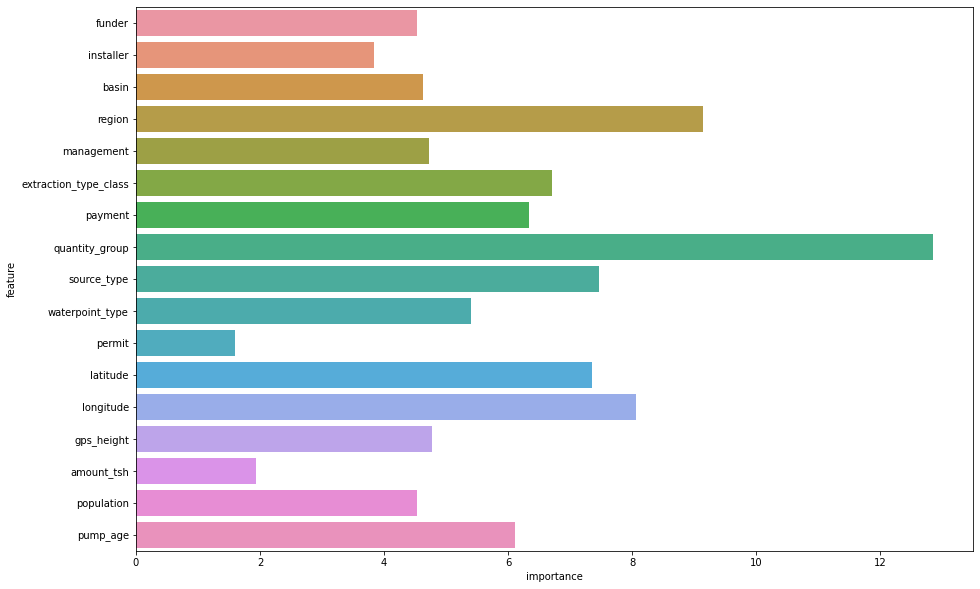

In [51]:
plt.figure(figsize=(15,10))
sns.barplot(y="feature", x="importance", data=feature_importance_df)

In hindsight, it apprears that features `is_missing_public_meeting`, `is_missing_permit`, `is_missing_population`, `quality_group`, `source_class`, and, `public_meeting` are of less importance to the model. It might be possible to remove these to get simplify the model

## Generate Test Predictions

In [52]:
preds_test = final_pipeline.predict(features_X_test)
preds_test = [pred[0] for pred in preds_test]
preds_test

preds_series = pd.Series(preds_test, name="status_group")

submission = X_test['id'].to_frame(name='id').merge(preds_series, left_index=True, right_index=True)

submission.to_csv('../submissions/attempt4.csv', index=False)